# Classifier for Noxious Plant Species in North America

* Student names: Natasha Kacoroski, Jacob Crabb
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Miles Erickson, Greg Damico


## Load Libraries and Data

In [550]:
# Import necessary libraries
from sklearn_pandas import DataFrameMapper, FunctionTransformer, gen_features
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.utils import resample
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

#in case of kernal shutdown problem
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.ensemble import RandomForestClassifier

import h2o 
from h2o.estimators.random_forest import H2ORandomForestEstimator

from sklearn.metrics import roc_curve

In [551]:
# Import data. Manually removed backslash symbols while troubleshooting data import (write function?)

plant_data = pd.read_csv("plants.csv", skiprows=9, low_memory=False)
plant_data.head()

,"outl0strokewidth0 strokec2 ""Accepted Symbol""",Synonym Symbol,Scientific Name,Common Name,Category,Duration,Growth Habit,Native Status,State Noxious Status,Active Growth Period,...,Propogated by Cuttings,Propogated by Seed,Propogated by Sod,Propogated by Sprigs,Propogated by Tubers,Seeds per Pound,Seed Spread Rate,Seedling Vigor,Small Grain,Vegetative Spread Rate
0,ABELI,NaN,Abelia,abelia,Dicot,NaN,NaN,L48(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABGR4,NaN,Abelia 'd7grandiflora,glossy abelia,Dicot,Perennial,Shrub,L48(I),NaN,"Spring, Summer, Fall",...,Yes,No,No,No,No,NaN,None,NaN,No,None
2,ABELM,NaN,Abelmoschus,okra,Dicot,NaN,NaN,L48(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABES,NaN,Abelmoschus esculentus,okra,Dicot,"Annual, Perennial","Subshrub, Forb/herb",L48(I)PR(I)VI(I),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABIES,NaN,Abies,fir,Gymnosperm,NaN,NaN,"L48(I,N)CAN(N)SPM(N)",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [552]:
plant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38186 entries, 0 to 38185
Data columns (total 78 columns):
outl0strokewidth0 strokec2 "Accepted Symbol"    38186 non-null object
Synonym Symbol                                  66 non-null object
Scientific Name                                 38185 non-null object
Common Name                                     36115 non-null object
Category                                        38046 non-null object
Duration                                        27808 non-null object
Growth Habit                                    34269 non-null object
Native Status                                   38093 non-null object
State Noxious Status                            461 non-null object
Active Growth Period                            2027 non-null object
After Harvest Regrowth Rate                     1039 non-null object
Bloat                                           2063 non-null object
C:N Ratio                                       1840 non-nu

Column information found here https://plants.usda.gov/charinfo.html.

## Clean Data

Many columns have the same 2,063 entries, subset to 2,063 entries for classification model.

In [553]:
plant_data.dropna(subset=['Bloat'], inplace=True) # Bloat is first column with 2,063 entries
plant_data.reset_index(drop=True, inplace=True) # Reset index

State Noxious Status column contains target data. Add column where 1 is noxious and 0 is not.

In [554]:
plant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2063 entries, 0 to 2062
Data columns (total 78 columns):
outl0strokewidth0 strokec2 "Accepted Symbol"    2063 non-null object
Synonym Symbol                                  66 non-null object
Scientific Name                                 2063 non-null object
Common Name                                     1997 non-null object
Category                                        1997 non-null object
Duration                                        1995 non-null object
Growth Habit                                    1995 non-null object
Native Status                                   1997 non-null object
State Noxious Status                            67 non-null object
Active Growth Period                            2027 non-null object
After Harvest Regrowth Rate                     1039 non-null object
Bloat                                           2063 non-null object
C:N Ratio                                       1840 non-null object


In [555]:
plant_data['invasive'] = plant_data['State Noxious Status'].notnull().astype('int')

Following are functions for mapper.

In [556]:
def select_features(dataframe, dtype, exclude_list):
    """Returns list of columns names to include as features"""
    columns = list(dataframe.select_dtypes(include=dtype).columns.values)
    features = [e for e in columns if e not in exclude_list]
    return features

def common_value(x):
    """Return most common value"""
    if ',' in x:
        return x.split(',')[0]
    else:
        return x
    
def bin_category(x):
    """Return categories with low value counts in a bin"""
    if (x == 'Dicot') or (x == 'Monocot') or (x == 'Gymnosperm'):
        return x
    else:
        return 'Other'
    
def num_of_growth_seasons(x):
    """Return growth period length"""
    one_season = ['Spring', 'Summer', 'Fall']
    two_seasons = ['Spring and Summer', 'Summer and Fall', 'Spring and Fall']
    three_seasons = ['Spring, Summer, Fall', 'Fall, Winter and Spring']
    if x in one_season:
        return 'one'
    elif x in two_seasons:
        return 'two'
    elif x in three_seasons:
        return 'three'
    else:
        return 'four'

def binarize_bloat(x):
    """Return one if any bloat and zero if none"""
    if x == 'None':
        return 0
    else:
        return 1
    
def binarize_foliage_color(x):
    """Return one if green and zero if not green"""
    not_green = ['White-Gray', 'Red']
    if x in not_green:
        return 0
    else:
        return 1
    
def binarize_nitrogen_fixation(x):
    """Return one if a nitrogen fixer and zero if not"""
    if x == 'None':
        return 0
    else:
        return 1
    
def erect_shape(x):
    """Return one if shape erect and zero if not"""
    erect = ['Erect', 'Semi-Erect']
    if x in erect:
        return 1
    else:
        return 0
    
def binarize_toxicity(x):
    """Return one if toxic and zero if not"""
    if x == 'None':
        return 0
    else:
        return 1
    
def bloom_period(x):
    """Return generalized bloom period"""
    spring = ['Late Spring', 'Mid Spring', 'Spring', 'Early Spring']
    summer = ['Summer', 'Early Summer', 'Mid Summer', 'Late Summer']
    if x in spring:
        return 'spring'
    elif x in summer:
        return 'summer'
    else:
        return 'other'
    
def seed_abundance(x):
    """Return seed abundance with low and none as one category"""
    if (x =='Low') or (x == 'None'):
        return 'low_none'
    else:
        return x
    
def seed_start(x):
    """Return seed start with year round and winter as one category"""
    if (x =='Year Round') or (x == 'Winter'):
        return 'other'
    else:
        return x
    
def seed_end(x):
    """Return seed end with year round and winter as one category"""
    if (x =='Year Round') or (x == 'Winter'):
        return 'other'
    else:
        return x
    
    
def imbalanced_class_metrics(train_target,
                             train_preds,
                             test_target,
                             test_preds):
    
    """Show alternative metrics for imbalanced class data.
    Show results of accuracy_score, f1_score, confusion_matrix, 
    classification_report, and roc_auc_score"""
    
    from sklearn.metrics import (accuracy_score,
                             f1_score,
                             confusion_matrix,
                             classification_report,
                             roc_auc_score)
    
    print('Training accuracy: ', accuracy_score(train_preds, train_target), '\n', 
          'Testing accuracy: ', accuracy_score(test_preds, test_target), '\n\n',
          'Classificaiton repot: ', classification_report(test_target, test_preds), '\n',
          'fr score: ', f1_score(test_target, test_preds), '\n', '\n',
          'Confusion Matrix: ', '\n', confusion_matrix(test_target, test_preds), '\n\n',
          'Train AUC: ', roc_auc_score(train_target, train_preds), '\n\n',
          'Test AUC: ', roc_auc_score(test_target, test_preds), '\n\n')

In [557]:
cat_mapper = DataFrameMapper([
    (['Category'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(bin_category)], {'alias':'category'}),
    (['Duration'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(common_value)], {'alias':'duration'}),
    (['Growth Habit'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(common_value)], {'alias':'growth_habit'}),
    (['Active Growth Period'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(num_of_growth_seasons)], {'alias':'num_of_growth_seasons'}),
    (['Bloat'], FunctionTransformer(binarize_bloat), {'alias':'bloat'}),
    (['C:N Ratio'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent')], {'alias':'cn_ratio'}),
    (['Coppice Potential'], None, {'alias':'cop_potential'}),
    (['Fall Conspicuous'], None, {'alias':'fall_conspicuous'}),
    (['Fire Resistance'], None, {'alias':'fire_resistance'}),
    (['Flower Color'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent')], {'alias':'flower_color'}),
    (['Flower Conspicuous'], None, {'alias':'flower_conspicuous'}),
    (['Foliage Color'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(binarize_foliage_color)], {'alias':'leaf_color'}),
    (['Foliage Porosity Summer'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'leaf_por_summer'}),
    (['Foliage Porosity Winter'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'leaf_por_winter'}),
    (['Foliage Texture'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'leaf_texture'}),
    (['Fruit Color'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'fruit_color'}),
    (['Fruit Conspicuous'], None, {'alias':'fruit_conspicuous'}),
    (['Growth Form'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'growth_form'}),
    (['Growth Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'growth_rate'}),
    (['Known Allelopath'], None, {'alias':'allelopath'}),
    (['Leaf Retention'], None, {'alias':'leaf_retention'}),
    (['Lifespan'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'lifespan'}),
    (['Low Growing Grass'], None, {'alias':'grass'}),
    (['Nitrogen Fixation'], FunctionTransformer(binarize_nitrogen_fixation), {'alias':'n_fixation'}),
    (['Resprout Ability'], None, {'alias':'resprout'}),
    (['Shape and Orientation'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(erect_shape)], {'alias':'erect_shape'}),
    (['Toxicity'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(binarize_toxicity)], {'alias':'toxicity'}),
    (['Adapted to Coarse Textured Soils'], None, {'alias':'coarse_soil'}),
    (['Adapted to Medium Textured Soils'], None, {'alias':'medium_soil'}),
    (['Adapted to Fine Textured Soils'], None, {'alias':'fine_soil'}),
    (['Anaerobic Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'anaerobic_tolerance'}),
    (['CaCO<SUB>3</SUB> Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'caco_tolerance'}),
    (['Cold Stratification Required'], None, {'alias':'cold_strat'}),
    (['Drought Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'drought_tolerance'}),
    (['Fertility Requirement'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'fertility_recs'}),
    (['Fire Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'fire_tolerance'}),
    (['Hedge Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'hedge_tolerance'}),
    (['Moisture Use'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'moisture_use'}),
    (['Salinity Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'salt_tolerance'}),
    (['Shade Tolerance'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'shade_tolerance'}),
    (['Bloom Period'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(bloom_period)], {'alias':'bloom_period'}),
    (['Fruit/Seed Abundance'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(seed_abundance)], {'alias':'seed_abundance'}),
    (['Fruit/Seed Period Begin'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(seed_start)], {'alias':'seed_start'}),
    (['Fruit/Seed Period End'], [SimpleImputer(missing_values=np.nan, strategy='most_frequent'), FunctionTransformer(seed_end)], {'alias':'seed_end'}),
    (['Fruit/Seed Persistence'], None, {'alias':'seed_persistence'}),
    (['Seed Spread Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'seed_spread_rate'}),
    (['Seedling Vigor'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'seed_vigor'}),
    (['Vegetative Spread Rate'], SimpleImputer(missing_values=np.nan, strategy='most_frequent'), {'alias':'seed_vigor'})],
    input_df=True, df_out=True)


cat_pipeline = Pipeline(steps=[
    ('clean', cat_mapper)
    ,
    ('preprocess', OneHotEncoder())
])

num_features = gen_features(columns=[['Height, Mature (feet)'],
                                     ['Frost Free Days, Minimum'],
                                     ['pH (Minimum)'],
                                     ['pH (Maximum)'],
                                     ['Precipitation (Minimum)'],
                                     ['Precipitation (Maximum)'],
                                     ['Root Depth, Minimum (inches)'],
                                     ["Temperature, Minimum ('b0F)"]],
                            classes=[{'class': SimpleImputer, 'missing_values':
                                     np.nan, 'strategy':'median'},
                                     StandardScaler])

num_mapper = DataFrameMapper(num_features, df_out=True, input_df=True)

union = FeatureUnion([('cat_features', cat_pipeline),
                     ('num_features', num_mapper)])

In [558]:
numeric_features = ['Height, Mature (feet)',
                    'Frost Free Days, Minimum',
                    'pH (Minimum)',
                    'pH (Maximum)',
                    'Precipitation (Minimum)',
                    'Precipitation (Maximum)',
                    'Root Depth, Minimum (inches)',
                    "Temperature, Minimum ('b0F)"]

In [559]:
X = plant_data.drop('invasive', axis=1)
y = plant_data['invasive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [560]:
np.all(X_test.index == y_test.index)

True

In [561]:
X_train_clean = union.fit_transform(X_train)
X_test_clean = union.transform(X_test)

# to view as dataframe, unhash below
column_names = cat_pipeline.named_steps['preprocess'].get_feature_names().tolist() + numeric_features
pd.DataFrame(union.fit_transform(X_train).toarray(), columns=column_names).T.head()

,0,1,2,3,4,5,6,7,8,9,...,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649
x0_Dicot,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
x0_Gymnosperm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x0_Monocot,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
x0_Other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x1_Annual,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [562]:
X_train_clean_df = pd.DataFrame(union.fit_transform(X_train).toarray(),
                                columns=column_names,
                               index=X_train.index)
X_test_clean_df = pd.DataFrame(union.fit_transform(X_test).toarray(),
                               columns=column_names,
                               index=X_test.index)

In [563]:
#X_test_clean_df.columns
[(i,name) for i,name in enumerate(column_names) if type(name) != str]

[]

In [564]:
# #Fitting the PCA algorithm with our Data
# pca = PCA().fit(X_train_clean_df)
# #Plotting the Cumulative Summation of the Explained Variance
# plt.figure()
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)') #for each component
# plt.title('Invasive Plants Dataset Explained Variance')
# plt.show()

In [565]:
# pca = PCA(n_components=80)
# X_train_pca = pca.fit_transform(X_train_clean_df)
# X_test_pca = pca.transform(X_test_clean_df)

In [566]:
# pca.explained_variance_ratio_

In [567]:

pca_df = pd.DataFrame(data=X_train_clean_df)

sm = SMOTE(sampling_strategy='minority',
           k_neighbors=30,
           n_jobs=3,
           random_state=9)

# sm = RandomOverSampler(sampling_strategy='minority')

X_res, y_res = sm.fit_resample(pca_df, y_train)

In [568]:
X_res.shape, y_res.shape

((3190, 164), (3190,))

In [569]:
# #rfc = H2ORandomForestEstimator()
# rfc = XGBClassifier(max_depth=3,
#                     scale_pos_weight=2,
#                     learning_rate=0.01)
# # rfc = RandomForestClassifier(n_estimators=100,
# #                              max_depth=4,
# #                              random_state=2,
# #                              class_weight={1:2})
# rfc.fit(X_res, y_res)

# rfc.score(X_res, y_res), rfc.score(X_test_pca, y_test)

# train_pred = rfc.predict(X_train_pca)
# test_pred = rfc.predict(X_test_pca)

In [570]:
imbalanced_class_metrics(y_train,
                         train_pred,
                         y_test,
                         test_pred)


Training accuracy:  0.6084848484848485 
 Testing accuracy:  0.6077481840193705 

 Classificaiton repot:                precision    recall  f1-score   support

           0       0.98      0.61      0.75       401
           1       0.04      0.50      0.07        12

   micro avg       0.61      0.61      0.61       413
   macro avg       0.51      0.56      0.41       413
weighted avg       0.95      0.61      0.73       413
 
 fr score:  0.06896551724137931 
 
 Confusion Matrix:  
 [[245 156]
 [  6   6]] 

 Train AUC:  0.48150470219435737 

 Test AUC:  0.5554862842892768 




In [736]:
rfc = RandomForestClassifier(n_estimators=100,
                             random_state=42,
                             max_depth=4)
rfc.fit(X_train_clean_df, y_train)

#X_test_clean_df

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [737]:
y_train_pred = rfc.predict_proba(X_train_clean_df)
y_test_pred = rfc.predict_proba(X_test_clean_df)

In [738]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred[:,1])

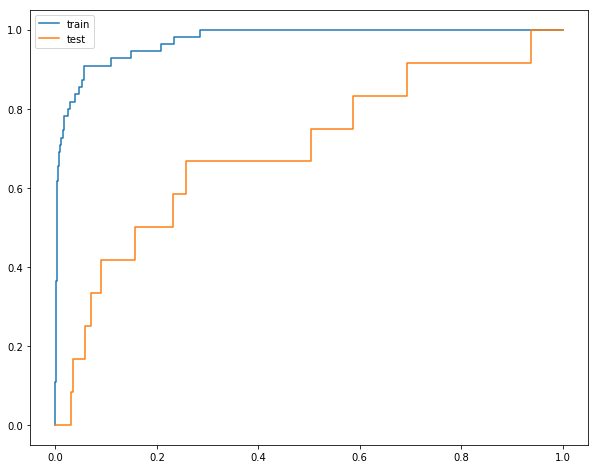

In [739]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

(array([127., 169.,  77.,  19.,  12.,   3.,   1.,   2.,   2.,   1.]),
 array([0.00954558, 0.02175361, 0.03396164, 0.04616967, 0.0583777 ,
        0.07058573, 0.08279376, 0.09500179, 0.10720982, 0.11941784,
        0.13162587]),
 <a list of 10 Patch objects>)

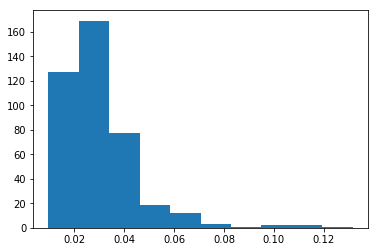

In [659]:
plt.hist(y_test_pred[:,1])

In [660]:
test_thresholds

array([1.13162587, 0.13162587, 0.06688249, 0.0665343 , 0.06312329,
       0.0626692 , 0.05699582, 0.05555486, 0.05306062, 0.05246668,
       0.04653059, 0.04607398, 0.04077429, 0.04073968, 0.03570654,
       0.03560565, 0.03475246, 0.03472021, 0.02680804, 0.0267905 ,
       0.02449298, 0.02447347, 0.02171356, 0.02164603, 0.01594317,
       0.01588451, 0.00954558])

In [661]:
y_test_pred[:,1][:7]

array([0.02754671, 0.02603367, 0.02491727, 0.01949869, 0.01818909,
       0.02545231, 0.01598686])

In [663]:
miles_talk_copy = X_test_clean_df.copy()

In [665]:
miles_talk_copy['y'] = y_test

In [666]:
miles_talk_copy['y_pred'] = y_test_pred[:,1]

In [676]:
miles_talk_copy.sort_values('y_pred', ascending=False).head()

,x0_Dicot,x0_Gymnosperm,x0_Monocot,x0_Other,x1_Annual,x1_Biennial,x1_Perennial,x2_Forb/herb,x2_Graminoid,x2_Shrub,...,"Height, Mature (feet)","Frost Free Days, Minimum",pH (Minimum),pH (Maximum),Precipitation (Minimum),Precipitation (Maximum),"Root Depth, Minimum (inches)","Temperature, Minimum ('b0F)",y,y_pred
1803,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.348985,-0.755315,-0.071197,0.693993,-0.559524,-0.683483,0.916216,-1.781052,0,0.131626
1769,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,-0.437258,-0.522114,-0.435714,2.007555,0.731445,0.324037,-0.326128,-0.766579,0,0.117108
715,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,-0.449028,-0.833048,-0.192703,0.431281,0.215057,0.324037,-0.119070,-0.969473,0,0.116051
1343,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.348985,0.877091,0.171814,-0.882281,0.731445,-0.107757,-0.533185,-0.644842,0,0.104338
306,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,-0.407834,3.364566,-1.043242,-1.276350,0.989638,0.727045,-0.326128,1.911632,0,0.101827


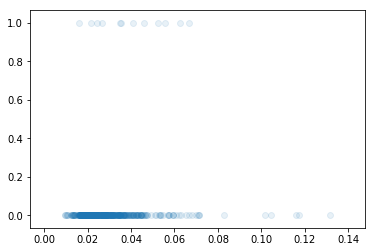

In [668]:
plt.scatter(miles_talk_copy['y_pred'], miles_talk_copy['y'], alpha=.1)

In [671]:
from sklearn.linear_model import LogisticRegression

In [675]:
lg = LogisticRegression(penalty='l2',
                       solver='lbfgs',
                       max_iter=1001)
lg.fit(X_train_clean_df, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1001, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

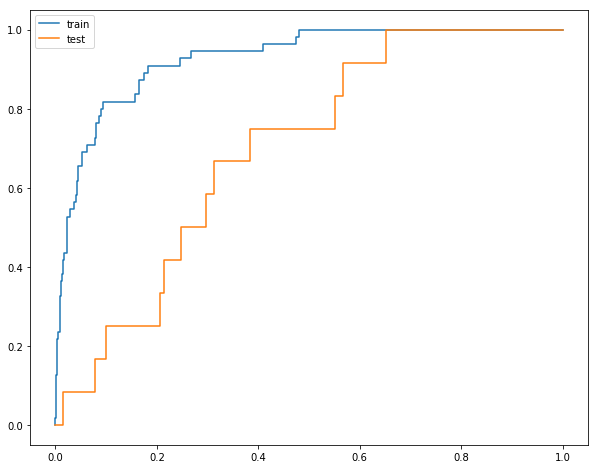

In [683]:
train_pred = lg.predict_proba(X_train_clean_df)
test_pred = lg.predict_proba(X_test_clean_df)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [692]:
test = lg.coef_.tolist()

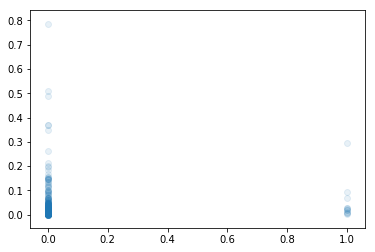

In [740]:
coef_df = X_test_clean_df.copy()
X_train_copy = X_train_clean_df.copy()
coef_df['y'] = y_test
coef_df['y_pred'] = test_pred[:,1]

plt.scatter(coef_df['y'], coef_df['y_pred'], alpha=0.1);

In [708]:
coef_list = list(zip(X_train_clean_df.columns, test[0]))

In [718]:
coefs_sorted = sorted(coef_list, key= lambda x: x[1], reverse=True)
coefs_sorted

[('x47_Rapid', 0.8697597082191184),
 ('x17_Bunch', 0.8147412619291718),
 ('x15_Yellow', 0.7889408450991463),
 ('x45_Moderate', 0.7511426494791614),
 ('x36_Medium', 0.6875026264370211),
 ('x42_Spring', 0.6727318497853074),
 ('x20_No', 0.6099286924248644),
 ('x34_Medium', 0.5906348087590693),
 ('x16_Yes', 0.5902331111358089),
 ('x11_0', 0.5183372063612273),
 ('Precipitation (Minimum)', 0.5106739115523179),
 ('x4_0', 0.5101547596223364),
 ('x35_None', 0.4723178952913498),
 ('x30_Low', 0.4706381812329287),
 ('x13_Moderate', 0.4667358599789242),
 ('x31_None', 0.45489437781897213),
 ('x2_Vine', 0.45412013475349583),
 ('x26_1', 0.44221389057614063),
 ('x42_Summer', 0.4401768181449345),
 ('x17_Colonizing', 0.4085477504536163),
 ('x38_High', 0.39559584904530903),
 ('x33_High', 0.38595339084515395),
 ('x6_Yes', 0.384195932071269),
 ('x3_one', 0.3782445467043123),
 ("Temperature, Minimum ('b0F)", 0.367233051359651),
 ('x17_Stoloniferous', 0.36653136937640457),
 ('x15_Green', 0.3639287094146679),


In [741]:
top_coefs = [x[0] for x in coefs_sorted if abs(x[1]) > 0.5]
best_coef_x_test = coef_df[top_coefs]
best_coef_x_train = X_train_copy[top_coefs]

In [746]:
lg2 = LogisticRegression(penalty='l2',
                       solver='lbfgs',
                       max_iter=1001)
lg2.fit(best_coef_x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1001, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

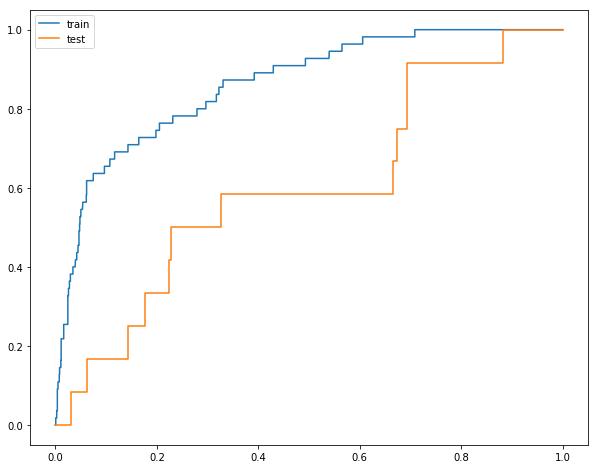

In [747]:
train_pred = lg2.predict_proba(best_coef_x_train)
test_pred = lg2.predict_proba(best_coef_x_test)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [758]:
rfc2 = RandomForestClassifier(n_estimators=100,
                             random_state=42,
                             max_depth=2)
rfc2.fit(best_coef_x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

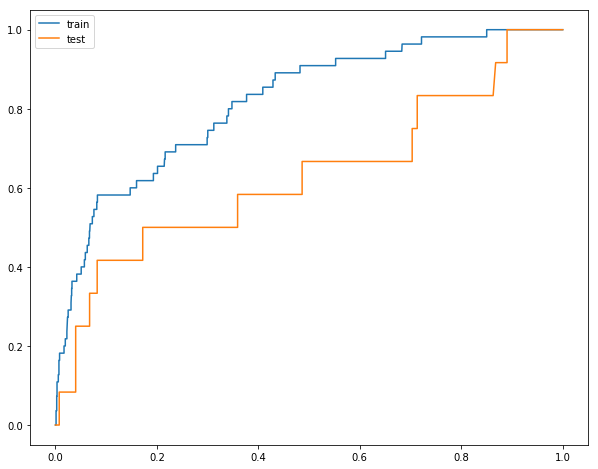

In [759]:
train_pred = rfc2.predict_proba(best_coef_x_train)
test_pred = rfc2.predict_proba(best_coef_x_test)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();

In [796]:
xgb = XGBClassifier(max_depth=2,
                    scale_pos_weight=1,
                    learning_rate=0.1)

xgb.fit(best_coef_x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

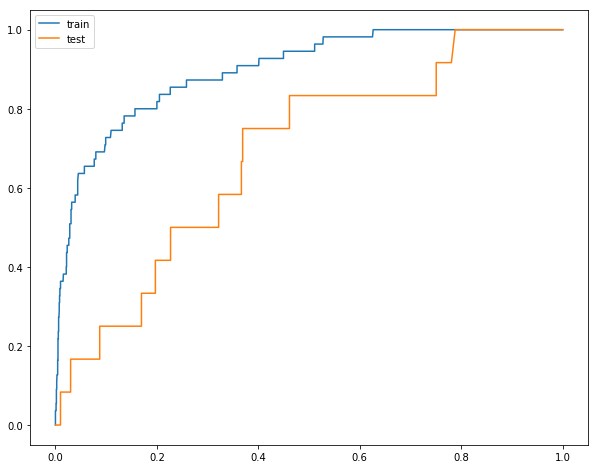

In [797]:
train_pred = xgb.predict_proba(best_coef_x_train)
test_pred = xgb.predict_proba(best_coef_x_test)
fpr, tpr, thresholds = roc_curve(y_train, train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, test_pred[:,1])
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr,tpr, label='train')
ax.plot(test_fpr, test_tpr, label='test')
plt.legend();